In [2]:
import tensorflow as tf
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import PIL

In [3]:
from tensorflow.keras import layers
import pickle
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [4]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()


170500096/170498071 [==============================] - 2s 0us/step


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.1,shuffle=True)

In [7]:
x_train=x_train/255
x_val=x_val/255
x_test=x_test/255

In [8]:
print(x_train.shape,x_val.shape,x_test.shape,y_train.shape,y_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3) (45000, 1) (10000, 1)


### Building and Training Residual Model

In [9]:
def resblock(X,filter,stage):
    #convolutional Block
    X_copy=X
    f1,f2,f3=filter
    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = MaxPool2D((2,2))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


    # Short path
    X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
    X_copy = MaxPool2D((2,2))(X_copy)
    X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    # Identity Block 1
    X_copy = X


    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    # Identity Block 2
    X_copy = X


    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [14]:
input_shape = (32, 32, 3)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = resblock(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = resblock(X, filter= [128, 128, 512], stage= 3)

# Average Pooling
X = AveragePooling2D((1, 1), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(10, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_ = Model( inputs= X_input, outputs = X, name = 'Custom_Resnet')

model_.summary()

Model: "Custom_Resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
______________________________________________________________________________________

In [15]:
# Training The Network
model_.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [16]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# Saving the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "Cifar10.hdf5", verbose = 1, save_best_only=True)

In [17]:
from keras.utils import to_categorical

y_train_encoded = to_categorical(y_train)
y_val_encoded=to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

In [20]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 99.8% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()
history = model_.fit(x_train,y_train_encoded,
          validation_data=(x_val, y_val_encoded), steps_per_epoch=len(x_train) // 64,
          epochs= 30, callbacks=[callbacks])

Epoch 1/30
703/703 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9668
Reached 99.8% accuracy so cancelling training!
703/703 [==============================] - 178s 253ms/step - loss: 0.0974 - accuracy: 0.9668 - val_loss: 2.0802 - val_accuracy: 0.6122


## Normal Conv

In [21]:
score = model_.evaluate(x_test, y_test_encoded)
print('Test Accuracy: {}'.format(score[1]))

313/313 [==============================] - 8s 25ms/step - loss: 2.0898 - accuracy: 0.6183
Test Accuracy: 0.6183000206947327


In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

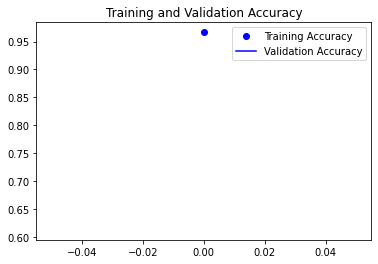

In [24]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


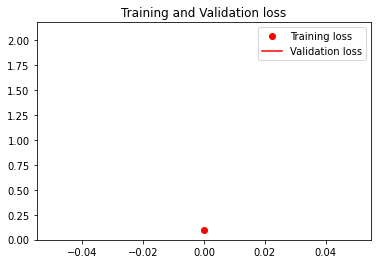

In [25]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [34]:
classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [26]:
predicted_classes = np.argmax(model_.predict(x_test), axis=-1)
y_true = np.argmax(y_test_encoded, axis=-1)

In [37]:
#classes[predicted_classes[0]]
y_true

array([3, 8, 8, ..., 5, 1, 7])

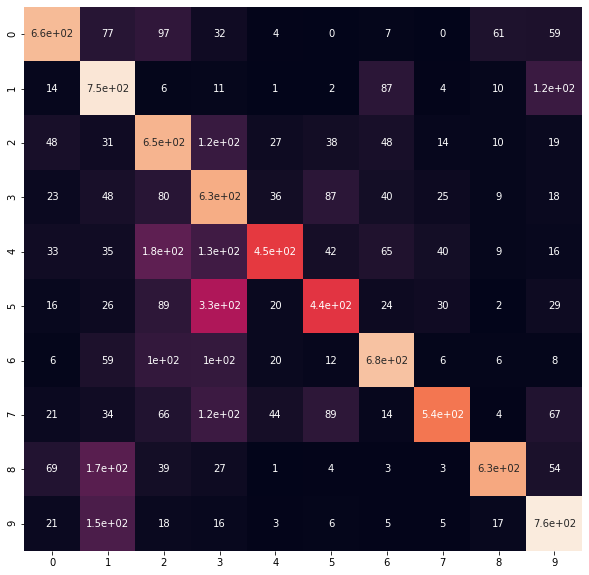

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

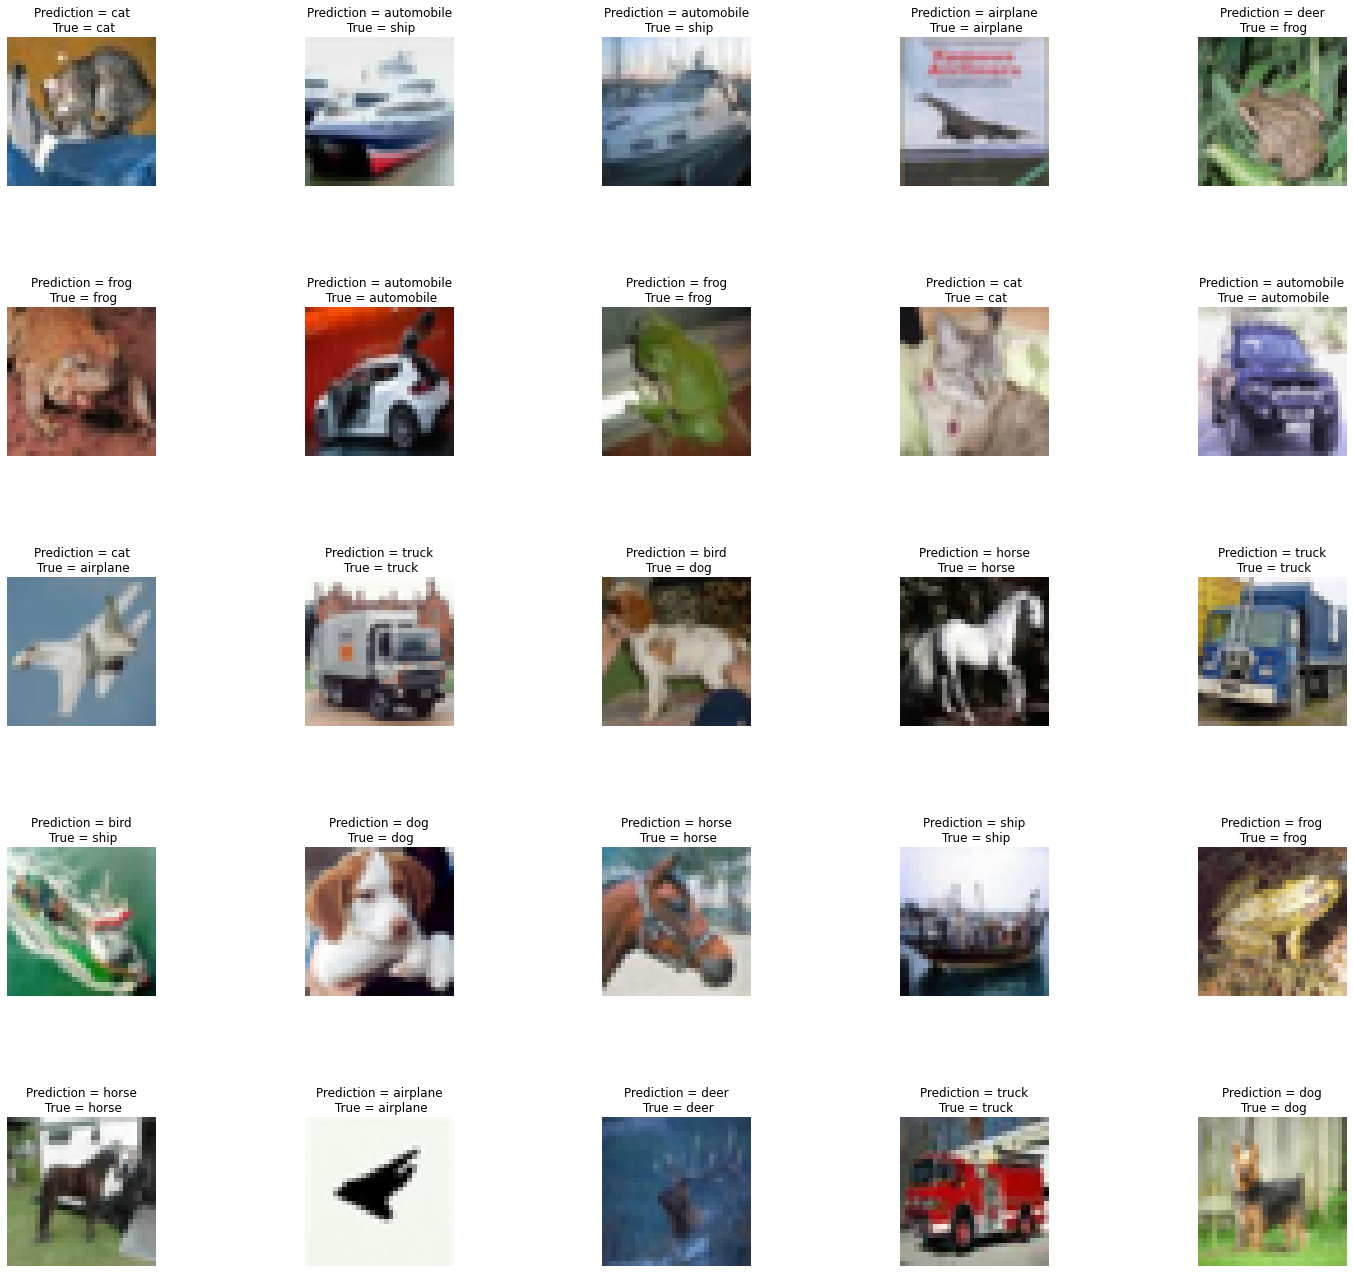

In [36]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(x_test[i], cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(classes[predicted_classes[i]], classes[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)   